In [1]:
#Removing less than 20
import numpy as np
import glob
import SimpleITK as sitk
from tqdm import tqdm
import pydicom
from skimage import measure, color
import random

file = glob.glob('./data/*')
num=[]
image = []
mask = []
imagefile = []
maskfile = []

for i in file:
    mfile = glob.glob(i + '/*.nii.gz')
    if len(mfile) == 0:
        mfile = glob.glob(i + '/*.nii')
    maskfile.append(mfile[0])

for i in tqdm(range(len(file))):
    dicomp=glob.glob(file[i]+'/*.dcm')
    ds=sitk.ReadImage(dicomp[0])
    files = file[i].replace('data', 'brain_data')
    iii = sitk.ReadImage(files + '/image.nii.gz')
    #    iii = sitk.Cast(iii, sitk.sitkFloat32)
    #    img_mask = sitk.BinaryNot(sitk.BinaryThreshold(iii, 0, 0))
    #    iii = sitk.N4BiasFieldCorrection(iii, img_mask)
    ii = sitk.GetArrayFromImage(iii)
    ii=np.clip(ii,0,2000)
    m = sitk.ReadImage(maskfile[i])
    mm = sitk.GetArrayFromImage(m)
    unitVol=np.prod(ds.GetSpacing())
    labels = measure.label(mm)
    region = measure.regionprops(labels)
    for j in region:
        bbox = j.bbox
        (x, y, z) = ((bbox[4] + bbox[1]) / 2, (bbox[5] + bbox[2]) / 2,
                     (bbox[3] + bbox[0]) / 2)
        (x, y, z) = (int(x), int(y), int(z))
        counts=np.sum(mm[bbox[0]:bbox[-3],bbox[1]:bbox[-2],bbox[2]:bbox[-1]])
        if counts*unitVol>20:       
            if z - 40 <= 0:
                p = ii[0:80, x - 64:x + 64, y - 64:y + 64]
                pp = mm[0:80, x - 64:x + 64, y - 64:y + 64]
            elif z + 40 >= len(mm):
                p = ii[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
                pp = mm[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
            else:
                p = ii[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
                pp = mm[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]

            if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
                xr=bbox[4]-x
                yr=bbox[5]-y
                xlim=(64-xr-15)
                ylim=(64-yr-15)
                xd=[i for i in range(x-xlim,x+xlim)]
                random.shuffle(xd)
                yd=[i for i in range(y-ylim,y+ylim)]
                random.shuffle(yd)

                for iy in xd:
                    for jy in yd:
                        if z - 40 <= 0:
                            p = ii[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                        elif z + 40 >= len(mm):
                            p = ii[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                        else:
                            p = ii[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]

                        if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
                            pass
                        else:
                            break
                    else:
                        continue
                    break
                else:
                    break

            image.append(p)
            mask.append(pp)

iArr = np.zeros((len(image), 80, 128, 128))
mArr = np.zeros((len(image), 80, 128, 128))
for i in range(len(image)):
    mean = np.mean(image[i])
    std = np.std(image[i])
    iArr[i, :, :, :] = (image[i] - mean) / (std)
    mArr[i, :, :, :] = mask[i]
del image
del mask
            
from tqdm import tqdm
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness,
    ShiftScaleRotate,
    Flip
)

sf = np.zeros((len(iArr),80,128,128))
sfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'水平翻转开始'+'*'*30)

for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = HorizontalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    sf[i]=image_h_flipped
    sfm[i]=mask_h_flipped

cf = np.zeros((len(iArr),80,128,128))
cfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'垂直翻转开始'+'*'*30)
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug =VerticalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    cf[i]=image_h_flipped
    cfm[i]=mask_h_flipped

print('*'*30+'弹性变换开始'+'*'*30)


wg = np.zeros((len(iArr),80,128,128))
wgm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = GridDistortion(p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    wg[i]=image_h_flipped
    wgm[i]=mask_h_flipped

 
r = np.zeros((len(iArr),80,128,128))
rm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=0.3, scale_limit=1e-9, rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    r[i]=image_h_flipped
    rm[i]=mask_h_flipped

rr = np.zeros((len(iArr),80,128,128))
rrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=(-0.2,0.2), rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rr[i]=image_h_flipped
    rrm[i]=mask_h_flipped

rrr = np.zeros((len(iArr),80,128,128))
rrrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=1e-9, rotate_limit=(-45,45), p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rrr[i]=image_h_flipped
    rrrm[i]=mask_h_flipped
    
img=np.concatenate((iArr,sf,cf,wg,r,rr,rrr),axis=0) 
msk=np.concatenate((mArr,sfm,cfm,wgm,rm,rrm,rrrm),axis=0) 

fimage=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
fmask=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
for i in tqdm(range(len(msk))):
#    min=np.mean(img[i])
#    max=np.std(img[i])
    fimage[i]=img[i]
    fmask[i]=msk[i]

rand_i = np.random.choice(range(len(fmask)),size=len(fmask),replace=False)
finali=fimage[rand_i]
finalm=fmask[rand_i]
np.save('./3Dran.npy',finali)
np.save('./3Dranm.npy',finalm)

ModuleNotFoundError: No module named 'SimpleITK'

In [1]:
#Removing less than 20 and 3D clahe
import numpy as np
import mclahe as mc
import glob
import SimpleITK as sitk
from tqdm import tqdm
import pydicom
from skimage import measure, color
import random

file = glob.glob('./data/*')
num=[]
image = []
mask = []
imagefile = []
maskfile = []

for i in file:
    mfile = glob.glob(i + '/*.nii.gz')
    if len(mfile) == 0:
        mfile = glob.glob(i + '/*.nii')
    maskfile.append(mfile[0])

for i in tqdm(range(len(file))):
    dicomp=glob.glob(file[i]+'/*.dcm')
    ds=sitk.ReadImage(dicomp[0])
    files = file[i].replace('data', 'brain_data')
    iii = sitk.ReadImage(files + '/image.nii.gz')
    #    iii = sitk.Cast(iii, sitk.sitkFloat32)
    #    img_mask = sitk.BinaryNot(sitk.BinaryThreshold(iii, 0, 0))
    #    iii = sitk.N4BiasFieldCorrection(iii, img_mask)
    ii = sitk.GetArrayFromImage(iii)
    ii=np.clip(ii,0,2000)
    m = sitk.ReadImage(maskfile[i])
    mm = sitk.GetArrayFromImage(m)
    unitVol=np.prod(ds.GetSpacing())
    labels = measure.label(mm)
    region = measure.regionprops(labels)
    for j in region:
        bbox = j.bbox
        (x, y, z) = ((bbox[4] + bbox[1]) / 2, (bbox[5] + bbox[2]) / 2,
                     (bbox[3] + bbox[0]) / 2)
        (x, y, z) = (int(x), int(y), int(z))
        counts=np.sum(mm[bbox[0]:bbox[-3],bbox[1]:bbox[-2],bbox[2]:bbox[-1]])
        if counts*unitVol>20:       
            if z - 40 <= 0:
                p = ii[0:80, x - 64:x + 64, y - 64:y + 64]
                pp = mm[0:80, x - 64:x + 64, y - 64:y + 64]
            elif z + 40 >= len(mm):
                p = ii[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
                pp = mm[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
            else:
                p = ii[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
                pp = mm[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]

            if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
                xr=bbox[4]-x
                yr=bbox[5]-y
                xlim=(64-xr-15)
                ylim=(64-yr-15)
                xd=[i for i in range(x-xlim,x+xlim)]
                random.shuffle(xd)
                yd=[i for i in range(y-ylim,y+ylim)]
                random.shuffle(yd)

                for iy in xd:
                    for jy in yd:
                        if z - 40 <= 0:
                            p = ii[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                        elif z + 40 >= len(mm):
                            p = ii[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                        else:
                            p = ii[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]
                            pp = mm[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]

                        if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
                            pass
                        else:
                            break
                    else:
                        continue
                    break
                else:
                    break
            voxel=mc.mclahe(p,kernel_size=[16,84,84],n_bins=256,clip_limit=0.01)
            image.append(voxel)
            mask.append(pp)

iArr = np.zeros((len(image), 80, 128, 128))
mArr = np.zeros((len(image), 80, 128, 128))
for i in range(len(image)):
    mean = np.mean(image[i])
    std = np.std(image[i])
    iArr[i, :, :, :] = (image[i] - mean) / (std)
    mArr[i, :, :, :] = mask[i]
del image
del mask
            
from tqdm import tqdm
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness,
    ShiftScaleRotate,
    Flip
)

sf = np.zeros((len(iArr),80,128,128))
sfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'水平翻转开始'+'*'*30)

for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = HorizontalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    sf[i]=image_h_flipped
    sfm[i]=mask_h_flipped

cf = np.zeros((len(iArr),80,128,128))
cfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'垂直翻转开始'+'*'*30)
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug =VerticalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    cf[i]=image_h_flipped
    cfm[i]=mask_h_flipped

print('*'*30+'弹性变换开始'+'*'*30)


wg = np.zeros((len(iArr),80,128,128))
wgm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = GridDistortion(p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    wg[i]=image_h_flipped
    wgm[i]=mask_h_flipped

 
r = np.zeros((len(iArr),80,128,128))
rm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=0.3, scale_limit=1e-9, rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    r[i]=image_h_flipped
    rm[i]=mask_h_flipped

rr = np.zeros((len(iArr),80,128,128))
rrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=(-0.2,0.2), rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rr[i]=image_h_flipped
    rrm[i]=mask_h_flipped

rrr = np.zeros((len(iArr),80,128,128))
rrrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=1e-9, rotate_limit=(-45,45), p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rrr[i]=image_h_flipped
    rrrm[i]=mask_h_flipped
    
img=np.concatenate((iArr,sf,cf,wg,r,rr,rrr),axis=0) 
msk=np.concatenate((mArr,sfm,cfm,wgm,rm,rrm,rrrm),axis=0) 

fimage=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
fmask=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
for i in tqdm(range(len(msk))):
#    min=np.mean(img[i])
#    max=np.std(img[i])
    fimage[i]=img[i]
    fmask[i]=msk[i]

rand_i = np.random.choice(range(len(fmask)),size=len(fmask),replace=False)
finali=fimage[rand_i]
finalm=fmask[rand_i]
np.save('./3Dclahe.npy',finali)
np.save('./3Dclahem.npy',finalm)

100%|██████████| 105/105 [06:56<00:00,  3.97s/it]


******************************水平翻转开始******************************


100%|██████████| 120/120 [00:00<00:00, 134.31it/s]


******************************垂直翻转开始******************************


100%|██████████| 120/120 [00:00<00:00, 156.83it/s]


******************************弹性变换开始******************************


100%|██████████| 840/840 [00:01<00:00, 421.29it/s]


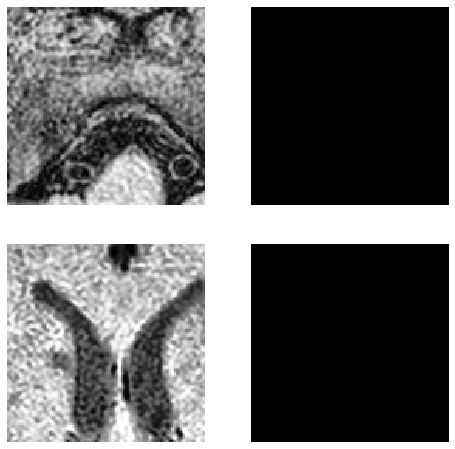

In [7]:
from matplotlib.animation import FuncAnimation, writers
import matplotlib.pyplot as plt
import os 

one=finali[50,0,:,:]
two=finalm[50,0,:,:]
three=finali[500,0,:,:]
four=finalm[500,0,:,:]
fig,ax=plt.subplots(2,2,figsize=(8,8))
def init():
    ax[0][0].imshow(one[0],'gray')
    ax[0][0].axis('off')
    ax[0][1].imshow(two[0],'gray')
    ax[0][1].axis('off')
    ax[1][0].imshow(three[0],'gray')
    ax[1][0].axis('off')
    ax[1][1].imshow(four[0],'gray')
    ax[1][1].axis('off')

def update(n):
    ax[0][0].clear()
    ax[0][0].imshow(one[n],'gray')
    ax[0][0].axis('off')
    ax[0][1].clear()
    ax[0][1].imshow(two[n],'gray')
    ax[0][1].axis('off')
    ax[1][0].clear()
    ax[1][0].imshow(three[n],'gray')
    ax[1][0].axis('off')
    ax[1][1].clear()
    ax[1][1].imshow(four[n],'gray')
    ax[1][1].axis('off')
ani=FuncAnimation(fig,update,frames=range(len(p)),interval=1000)
plt.show()
ani.save('./test.gif', writer='imagemagick', fps=3000)       

In [1]:
#最初没有去除小于20的动脉瘤
import numpy as np
import glob
import SimpleITK as sitk
from tqdm import tqdm
import pydicom
from skimage import measure, color
import random

file = glob.glob('./data/*')
num=[]
image = []
mask = []
imagefile = []
maskfile = []

for i in file:
    mfile = glob.glob(i + '/*.nii.gz')
    if len(mfile) == 0:
        mfile = glob.glob(i + '/*.nii')
    maskfile.append(mfile[0])

for i in tqdm(range(len(file))):
    dicomp=glob.glob(file[i]+'/*.dcm')
    ds=pydicom.read_file(dicomp[0])
    files = file[i].replace('data', 'brain_data')
    iii = sitk.ReadImage(files + '/image.nii.gz')
    #    iii = sitk.Cast(iii, sitk.sitkFloat32)
    #    img_mask = sitk.BinaryNot(sitk.BinaryThreshold(iii, 0, 0))
    #    iii = sitk.N4BiasFieldCorrection(iii, img_mask)
    ii = sitk.GetArrayFromImage(iii)
    ii=np.clip(ii,0,2000)
    m = sitk.ReadImage(maskfile[i])
    mm = sitk.GetArrayFromImage(m)
    labels = measure.label(mm)
    region = measure.regionprops(labels)
    for j in region:
        bbox = j.bbox
        (x, y, z) = ((bbox[4] + bbox[1]) / 2, (bbox[5] + bbox[2]) / 2,
                     (bbox[3] + bbox[0]) / 2)
        (x, y, z) = (int(x), int(y), int(z))
        
        if z - 40 <= 0:
            p = ii[0:80, x - 64:x + 64, y - 64:y + 64]
            pp = mm[0:80, x - 64:x + 64, y - 64:y + 64]
        elif z + 40 >= len(mm):
            p = ii[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
            pp = mm[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
        else:
            p = ii[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
            pp = mm[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
        
        if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
            xr=bbox[4]-x
            yr=bbox[5]-y
            xlim=(64-xr-15)
            ylim=(64-yr-15)
            xd=[i for i in range(x-xlim,x+xlim)]
            random.shuffle(xd)
            yd=[i for i in range(y-ylim,y+ylim)]
            random.shuffle(yd)
            
            for iy in xd:
                for jy in yd:
                    if z - 40 <= 0:
                        p = ii[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                        pp = mm[0:80, iy - 64:iy + 64, jy - 64:jy + 64]
                    elif z + 40 >= len(mm):
                        p = ii[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                        pp = mm[len(mm) - 80:len(mm), iy - 64:iy + 64, jy - 64:jy + 64]
                    else:
                        p = ii[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]
                        pp = mm[z - 40:z + 40, iy - 64:iy + 64, jy - 64:jy + 64]
                        
                    if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
                        pass
                    else:
                        break
                else:
                    continue
                break
            else:
                break
            
        image.append(p)
        mask.append(pp)

iArr = np.zeros((len(image), 80, 128, 128))
mArr = np.zeros((len(image), 80, 128, 128))
for i in range(len(image)):
    mean = np.mean(image[i])
    std = np.std(image[i])
    iArr[i, :, :, :] = (image[i] - mean) / (std)
    mArr[i, :, :, :] = mask[i]
del image
del mask
            
from tqdm import tqdm
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness,
    ShiftScaleRotate,
    Flip
)

sf = np.zeros((len(iArr),80,128,128))
sfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'水平翻转开始'+'*'*30)

for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = HorizontalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    sf[i]=image_h_flipped
    sfm[i]=mask_h_flipped

cf = np.zeros((len(iArr),80,128,128))
cfm = np.zeros((len(iArr),80,128,128))

print('*'*30+'垂直翻转开始'+'*'*30)
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug =VerticalFlip(p=0.9)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    cf[i]=image_h_flipped
    cfm[i]=mask_h_flipped

print('*'*30+'弹性变换开始'+'*'*30)


wg = np.zeros((len(iArr),80,128,128))
wgm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = GridDistortion(p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    wg[i]=image_h_flipped
    wgm[i]=mask_h_flipped

 
r = np.zeros((len(iArr),80,128,128))
rm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=0.3, scale_limit=1e-9, rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    r[i]=image_h_flipped
    rm[i]=mask_h_flipped

rr = np.zeros((len(iArr),80,128,128))
rrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=(-0.2,0.2), rotate_limit=1e-9, p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rr[i]=image_h_flipped
    rrm[i]=mask_h_flipped

rrr = np.zeros((len(iArr),80,128,128))
rrrm = np.zeros((len(iArr),80,128,128))
for i in tqdm(range(len(iArr))):
    image=iArr[i]
    mask=mArr[i]
    aug = ShiftScaleRotate(shift_limit=1e-9, scale_limit=1e-9, rotate_limit=(-45,45), p=1)
    augmented = aug(image=image, mask=mask)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    rrr[i]=image_h_flipped
    rrrm[i]=mask_h_flipped
    
img=np.concatenate((iArr,sf,cf,wg,r,rr,rrr),axis=0) 
msk=np.concatenate((mArr,sfm,cfm,wgm,rm,rrm,rrrm),axis=0) 

fimage=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
fmask=np.ndarray([len(msk),1,80,128,128],dtype=np.float32)
for i in tqdm(range(len(msk))):
#    min=np.mean(img[i])
#    max=np.std(img[i])
    fimage[i]=img[i]
    fmask[i]=msk[i]

rand_i = np.random.choice(range(len(fmask)),size=len(fmask),replace=False)
finali=fimage[rand_i]
finalm=fmask[rand_i]
np.save('./3Dran.npy',finali)
np.save('./3Dranm.npy',finalm)


#import matplotlib.pyplot as plt
#import imageio
#
#for k in range(len(mArr)):
#    image=[]
#    for i in range(80):
#        if np.any(mArr[k,i]>0):
#            image.append(mArr[k,i,:,:]*255)
#    imageio.mimsave('./visuale/sf/'+str(k)+'.gif', image, 'GIF', duration=1)  

 10%|████████                                                                        | 15/150 [00:00<00:00, 142.14it/s]

******************************水平翻转开始******************************


 11%|████████▌                                                                       | 16/150 [00:00<00:00, 155.11it/s]

******************************垂直翻转开始******************************


  3%|██▏                                                                               | 4/150 [00:00<00:04, 33.95it/s]

******************************弹性变换开始******************************


100%|█████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 382.43it/s]


In [36]:
import numpy as np
import glob
import numpy as np
import glob
import SimpleITK as sitk
from tqdm import tqdm
import pydicom
from skimage import measure, color
import random
from skimage import measure

file = glob.glob('./data/*')
num=[]
image = []
mask = []
imagefile = []
maskfile = []
q1=0
q2=0
q3=0
q4=0

for i in file:
    mfile = glob.glob(i + '/*.nii.gz')
    if len(mfile) == 0:
        mfile = glob.glob(i + '/*.nii')
    maskfile.append(mfile[0])

for i in maskfile:
    mask=sitk.ReadImage(i)
    mask=sitk.GetArrayFromImage(mask)
    labels=measure.label(mask)
    region=measure.regionprops(labels)
    for j in region:
        bbox=j.bbox
        counts=np.sum(mask[bbox[0]:bbox[-3],bbox[1]:bbox[-2],bbox[2]:bbox[-1]])
        unitVol=0.3*0.3*0.3
        if unitVol*counts<100:
            q1+=1
        elif 100<=unitVol*counts<=400:
            q2+=1
        elif 400<unitVol*counts<1000:
            q3+=1
        elif unitVol*counts>=1000:
            q4+=1
    

In [5]:
import numpy as np
import glob
import SimpleITK as sitk
from tqdm import tqdm
import pydicom
from skimage import measure, color
import random

file = glob.glob('./data/*')
num=[]
image = []
mask = []
qqq=[]
imagefile = []
maskfile = []
nn=0
for i in file:
    mfile = glob.glob(i + '/*.nii.gz')
    if len(mfile) == 0:
        mfile = glob.glob(i + '/*.nii')
    maskfile.append(mfile[0])

for i in tqdm(range(len(file))):
    dicomp=glob.glob(file[i]+'/*.dcm')
    ds=pydicom.read_file(dicomp[0])
    files = file[i].replace('data', 'brain_data')
    iii = sitk.ReadImage(files + '/image.nii.gz')
    #    iii = sitk.Cast(iii, sitk.sitkFloat32)
    #    img_mask = sitk.BinaryNot(sitk.BinaryThreshold(iii, 0, 0))
    #    iii = sitk.N4BiasFieldCorrection(iii, img_mask)
    ii = sitk.GetArrayFromImage(iii)
    ii=np.clip(ii,0,2000)
    m = sitk.ReadImage(maskfile[i])
    mm = sitk.GetArrayFromImage(m)
    labels = measure.label(mm)
    region = measure.regionprops(labels)
    for j in region:
        bbox = j.bbox
        (x, y, z) = ((bbox[4] + bbox[1]) / 2, (bbox[5] + bbox[2]) / 2,
                     (bbox[3] + bbox[0]) / 2)
        (x, y, z) = (int(x), int(y), int(z))
        
        if z - 40 <= 0:
            p = ii[0:80, x - 64:x + 64, y - 64:y + 64]
            pp = mm[0:80, x - 64:x + 64, y - 64:y + 64]
        elif z + 40 >= len(mm):
            p = ii[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
            pp = mm[len(mm) - 80:len(mm), x - 64:x + 64, y - 64:y + 64]
        else:
            p = ii[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
            pp = mm[z - 40:z + 40, x - 64:x + 64, y - 64:y + 64]
        
        if np.any(pp[:,0:30,:])==1 or np.any(pp[:,100:128,:])==1 or np.any(pp[:,:,0:30])==1 or np.any(pp[:,:,100:128])==1:
            nn+=1
            qqq.append(bbox)
            print(files)
            np.save('./servered'+str(nn)+'.npy',p)
            break
np.save('./bbox.npy',qqq)      

  4%|▎         | 4/113 [00:08<03:59,  2.19s/it]

./brain_data/humingfeng


  6%|▌         | 7/113 [00:15<03:56,  2.23s/it]

./brain_data/lijinlan



  7%|▋         | 8/113 [00:17<03:51,  2.20s/it]

./brain_data/LIFUSHENG


  9%|▉         | 10/113 [00:22<03:42,  2.16s/it]

./brain_data/sunjiazhi


 12%|█▏        | 14/113 [00:31<03:40,  2.22s/it]

./brain_data/huminhua


 15%|█▌        | 17/113 [00:37<03:28,  2.17s/it]

./brain_data/shenchangxiang


 17%|█▋        | 19/113 [00:41<03:22,  2.16s/it]

./brain_data/LISUYUN


 23%|██▎       | 26/113 [00:56<03:04,  2.12s/it]

./brain_data/dingjilan


 25%|██▍       | 28/113 [01:01<03:00,  2.13s/it]

./brain_data/wangdengyun


 27%|██▋       | 30/113 [01:05<02:56,  2.13s/it]

./brain_data/weipingzhen


 28%|██▊       | 32/113 [01:09<02:50,  2.11s/it]

./brain_data/mengxiangfeng


 33%|███▎      | 37/113 [01:20<02:48,  2.21s/it]

./brain_data/DONGJILIAN



 34%|███▎      | 38/113 [01:22<02:39,  2.12s/it]

./brain_data/HANCHENGXI


 39%|███▉      | 44/113 [01:35<02:27,  2.14s/it]

./brain_data/WANGXIAOJING


 42%|████▏     | 47/113 [01:41<02:22,  2.15s/it]

./brain_data/tangguoguang


 44%|████▍     | 50/113 [01:48<02:15,  2.15s/it]

./brain_data/liguowen


 48%|████▊     | 54/113 [01:56<02:07,  2.16s/it]

./brain_data/jiangjiafeng


 50%|█████     | 57/113 [02:03<01:58,  2.11s/it]

./brain_data/liliangtai


 58%|█████▊    | 65/113 [02:20<01:43,  2.17s/it]

./brain_data/wangxiangmei


 66%|██████▋   | 75/113 [02:42<01:22,  2.16s/it]

./brain_data/xuyuqi


 73%|███████▎  | 83/113 [02:59<01:04,  2.14s/it]

./brain_data/liujinxia



 74%|███████▍  | 84/113 [03:01<01:02,  2.15s/it]

./brain_data/ZHUOGENLIN



 75%|███████▌  | 85/113 [03:03<01:00,  2.15s/it]

./brain_data/zhangyongjing


 77%|███████▋  | 87/113 [03:07<00:56,  2.16s/it]

./brain_data/LIUSONGXIA


 85%|████████▍ | 96/113 [03:26<00:36,  2.13s/it]

./brain_data/liuchunyan


 93%|█████████▎| 105/113 [03:46<00:17,  2.17s/it]

./brain_data/luerzhuo


 98%|█████████▊| 111/113 [03:59<00:04,  2.16s/it]

./brain_data/luchunmei



 99%|█████████▉| 112/113 [04:01<00:02,  2.16s/it]

./brain_data/yuanaiping


100%|██████████| 113/113 [04:04<00:00,  2.16s/it]
